In [5]:
from scipy import misc
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib as mp
import os 

# --------------------------------------------------
# setup

def weight_variable(shape,wname):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''

    # IMPLEMENT YOUR WEIGHT_VARIABLE HERE
    initial = tf.contrib.layers.xavier_initializer()
    W=tf.Variable(initial(shape=shape), name=wname)
    return W

def bias_variable(shape, bname):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''

    # IMPLEMENT YOUR BIAS_VARIABLE HERE
    initial = tf.constant(0.1, shape=shape)
    b =tf.Variable(initial, name = bname)

    return b

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters = the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the filters, a.k.a. the results after convolution
    '''

    # IMPLEMENT YOUR CONV2D HERE
    h_conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    return h_conv

def max_pool_2x2(x, mpname):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''

    # IMPLEMENT YOUR MAX_POOL_2X2 HERE
    h_max = tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME',name ='mpname');
    return h_max

def variable_summaries(var, varname):
    with tf.name_scope(varname+'summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar(varname+'mean', mean)
        with tf.name_scope(varname+'stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar(varname+'stddev', stddev)
        tf.summary.scalar(varname+'max', tf.reduce_max(var))
        tf.summary.scalar(varname+'min', tf.reduce_min(var))
        tf.summary.histogram(varname+'histogram', var)


In [8]:
ntrain = 1000  # per class
ntest = 100 # per class
nclass = 10  # number of classes
imsize = 28
nchannels = 1


Train = np.zeros((ntrain*nclass,imsize,imsize,nchannels))
Test = np.zeros((ntest*nclass,imsize,imsize,nchannels))
LTrain = np.zeros((ntrain*nclass,nclass))
LTest = np.zeros((ntest*nclass,nclass))

itrain = -1
itest = -1
cwd = os.getcwd()
for iclass in range(0, nclass):
    for isample in range(0, ntrain):
        path = cwd + '/CIFAR10/Train/%d/Image%05d.png' % (iclass,isample)
        im = misc.imread(path); # 28 by 28
        im = im.astype(float)/255
        itrain += 1
        Train[itrain,:,:,0] = im
        LTrain[itrain,iclass] = 1 # 1-hot lable
    for isample in range(0, ntest):
        path = cwd + '/CIFAR10/Test/%d/Image%05d.png' % (iclass,isample)
        im = misc.imread(path); # 28 by 28
        im = im.astype(float)/255
        itest += 1
        Test[itest,:,:,0] = im
        LTest[itest,iclass] = 1 # 1-hot lable


In [ ]:
result_dir = cwd+'/results' # directory where the results from the training are saved
batchsize = 50
learning_rate = 1e-4
beta = 0.01
momentum = .9

sess = tf.Session()

# placeholders for input data and labels
tf_data = tf.placeholder(tf.float32, shape=[None,imsize,imsize,nchannels], name='InputData') #tf variable for the data, remember shape is [None, width, height, numberOfChannels] 
tf_labels = tf.placeholder(tf.float32,shape=[None,10], name='LabelData') #tf variable for labels

# --------------------------------------------------
# model
#create your model

keep_probfc = tf.placeholder(tf.float32, name='KeepProb')
keep_probconv = tf.placeholder(tf.float32, name='KeepConv')

#first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32], 'WeightsConv1')
variable_summaries(W_conv1,'WeightsConv1_')
b_conv1 = bias_variable([32], 'BiasConv1')
variable_summaries(b_conv1,'BiasConv1_')
h_conv1 = tf.nn.relu(conv2d(tf_data, W_conv1) + b_conv1, name='HiddenConv1')
variable_summaries(h_conv1,'HiddenConv1_')
h_pool1 = max_pool_2x2(h_conv1, 'HiddenMaxpool1')
variable_summaries(h_pool1,'HiddenMaxpool1_')
h_pool1_drop =tf.nn.dropout(h_pool1, keep_probconv, name='HiddenConv1Drop')

# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64], 'WeightsConv2')
b_conv2 = bias_variable([64], 'BiasConv2')
h_conv2 = tf.nn.relu(conv2d(h_pool1_drop, W_conv2) + b_conv2, name='HiddenConv2')
h_pool2 = max_pool_2x2(h_conv2, 'HiddenMaxpool2')
h_pool2_drop =tf.nn.dropout(h_pool2, keep_probconv, name='HiddenConv2Drop')


# densely connected layer
W_fc1 = weight_variable([7*7*64, 200], 'WeightsFc1')
b_fc1 =  bias_variable([200], 'BiasFc1')
with tf.name_scope('HiddenMaxpool2Flatten'):
    h_pool_reshape = tf.reshape(h_pool2_drop, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool_reshape, W_fc1) + b_fc1, name='HiddenFc1')

# dropout
h_fc1_drop =tf.nn.dropout(h_fc1, keep_probfc, name='HiddenFc1Drop')

# softmax
W_fc2 = weight_variable([200, 10], 'WeightsFc2')
#variable_summaries(W_fc2)
b_fc2 = bias_variable([10],'BiasFc2')
#variable_summaries(b_fc2)
with tf.name_scope('LabelProbabilities'):
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# --------------------------------------------------
# loss
#set up the loss, optimization, evaluation, and accuracy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_labels, logits=y_conv))
#regularizers = tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2)# L2 regularization
cross_entropy = tf.reduce_mean(cross_entropy)
tf.summary.scalar('cross_entropy', cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(tf_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# --------------------------------------------------
# optimization

# Create a saver for writing training checkpoints.
merged_summary_op = tf.summary.merge_all()
    
# Initializing the variables
init = tf.global_variables_initializer()

sess.run(init)
summary_writer = tf.summary.FileWriter(result_dir, sess.graph) # create summary writer
batch_xs = np.zeros([batchsize,imsize,imsize,nchannels]) #setup as [batchsize, width, height, numberOfChannels] and use np.zeros()
batch_ys = np.zeros([batchsize,nclass]) #setup as [batchsize, the how many classes] 
for i in range(60000): # try a small iteration size once it works then continue
    perm = np.arange(ntrain*nclass)
    np.random.shuffle(perm)
    for j in range(batchsize):
        batch_xs[j,:,:,:] = Train[perm[j],:,:,:]
        batch_ys[j,:] = LTrain[perm[j],:]
    _, c, summary = sess.run([train_step, cross_entropy, merged_summary_op], feed_dict={tf_data: batch_xs, tf_labels: batch_ys, keep_probfc: .5, keep_probconv: .5})
    
    if i%600 == 0:
        #calculate train accuracy and print it        
        #optimizer.run(feed_dict={tf_data: Test, tf_labels: LTest, keep_prob: 0.5}) # dropout only during training
        train_accuracy = accuracy.eval(session=sess,feed_dict={tf_data: batch_xs, tf_labels: batch_ys, keep_probfc: 1, keep_probconv: 1})
        print('step %d, training batch accuracy %g' % (i, train_accuracy))
        # Write logs at every iteration
        tf.summary.scalar('train_accuracy', train_accuracy)
        summary_writer.add_summary(summary, i) 
            
#summary_writer.flush()
#-------------------------------------------------
# test
print("test accuracy %g"%accuracy.eval(session=sess,feed_dict={tf_data: Test, tf_labels: LTest, keep_probfc: 1, keep_probconv: 1}))

#sess.close








step 0, training batch accuracy 0.14
step 600, training batch accuracy 0.24
step 1200, training batch accuracy 0.38
step 1800, training batch accuracy 0.38
step 2400, training batch accuracy 0.4
step 3000, training batch accuracy 0.36
step 3600, training batch accuracy 0.42
step 4200, training batch accuracy 0.52
step 4800, training batch accuracy 0.46
step 5400, training batch accuracy 0.42
step 6000, training batch accuracy 0.54
step 6600, training batch accuracy 0.56
step 7200, training batch accuracy 0.52
step 7800, training batch accuracy 0.64


In [651]:
tf.reset_default_graph()

In [684]:
#Select sample
batchstart = 0
batchsize2 = 10000
filteract = np.zeros(np.size(Train,0))
filternum = 9
batch_xs2 = np.zeros([1,imsize,imsize,nchannels]) #setup as [batchsize, width, height, numberOfChannels] and use np.zeros()
batch_ys2 = np.zeros([1,nclass]) #setup as [batchsize, the how many classes] 
#perm = np.arange(ntrain*nclass)
#np.random.shuffle(perm)
for j in range(np.size(Train,0)):
    batch_xs2[0,:,:,:] = Train[j,:,:,:]
    batch_ys2[0,:] = LTrain[j,:]
    act1 =h_pool1.eval(session=sess,feed_dict={tf_data: batch_xs2, tf_labels: batch_ys2, keep_probfc: 1, keep_probconv: 1})
    filteract[j]= np.sum(np.absolute(act1[:,:,:,filternum]))


2.27376


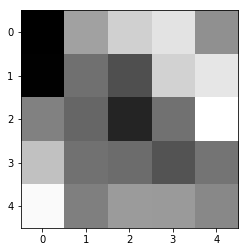

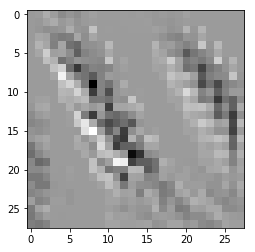

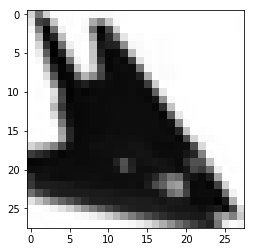

In [685]:
from PIL import Image
from scipy import signal
filteract_sort = np.argsort(filteract)
filteract_top = np.flip(filteract_sort[-10:],0)

for i in range(1):
    imageindex = filteract_top[0]
    batch_xs2[0,:,:,:] = Train[imageindex,:,:,:]
    batch_ys2[0,:] = LTrain[imageindex,:]
    h_pool1_act =h_pool1.eval(session=sess,feed_dict={tf_data: batch_xs2, tf_labels: batch_ys2, keep_probfc: 1, keep_probconv: 1})
    h_conv1_act =h_conv1.eval(session=sess,feed_dict={tf_data: batch_xs2, tf_labels: batch_ys2, keep_probfc: 1, keep_probconv: 1})
    switch_row = np.zeros((14,14))
    switch_col = np.zeros((14,14))
    relu_feat_map = h_conv1_act[-1,:,:,filternum]
    for j in range(14):
        for k in range(14):
            maxpoolarea = relu_feat_map[2*j:2*j+2,2*k:2*k+2]
            flat_maxpoolarea = maxpoolarea.flatten() 
            switch_flat = np.argmax(flat_maxpoolarea);
            switch_row[j,k] = np.floor(switch_flat/2)
            switch_col[j,k] = np.mod(switch_flat,2)
    h_unpool1 = np.zeros((28,28))
    pool_feat_map = h_pool1_act[-1,:,:,filternum]
    for j in range(14):
        for k in range(14):
            switch_unpool_row = int(2*j + switch_row[j,k])
            switch_unpool_col = int(2*k + switch_col[j,k])            
            h_unpool1[switch_unpool_row,switch_unpool_col] = relu_feat_map[j,k]

    h_relu_unpool1 = h_unpool1.clip(min=0)
    W_conv1_val = W_conv1.eval(session=sess)
    filter_main = W_conv1_val[:,:,-1,filternum]
    filter_trans = np.flip(filter_main,0)
    filter_trans = np.flip(filter_trans,1)
    recontrust = signal.convolve2d(h_relu_unpool1, filter_trans, boundary='symm', mode='same')
    batchim  = batch_xs2 [-1,:,:,-1]
    print(np.sum(np.absolute(filter_main)))
    plt.figure(0)
    plt.imshow(filter_main, cmap="gray")
    plt.show()
    plt.figure(1)
    plt.imshow(recontrust, cmap="gray")
    plt.show()
    plt.figure(2)
    plt.imshow(batchim, cmap="gray")
    plt.show()


In [4]:
import os 
cwd = os.getcwd()
print(cwd+ '\Ed')


C:\Users\henry_000\Python Projects\Elec576\Assignment 2\Ed
